# Tuesday, Feb 11: 

Likelihood: the product of the individual probability (or probabilities)

What do we do with the likelihood: 
    - We maximize the log likelihood to know that a given set of parameter values yield the best fit for our data and our hypothesis. 
    - We can find this maximum with gradient descent

He does not like writing "log" because it's ambiguous about the base. Write ln or log10. 

Because log likelihoods are a multiplication of a bunch of small numbers, we take the natural log (in order to avoid extremely small numbers and to simplify computation. 

Log likelihood equation
ln⁡(l)=∑_{i=1}^n▒〖ln⁡(f(x_i:λ)) 〗

Here is the log likelihood equation: 


If you fit you log likelihood to a non-infinite sample size, the resulting best fit parameters might be slightly different from what the true values are.  This is because the sample might have some random skew.

* TODO: should we be using a MC alg to generate the samples?

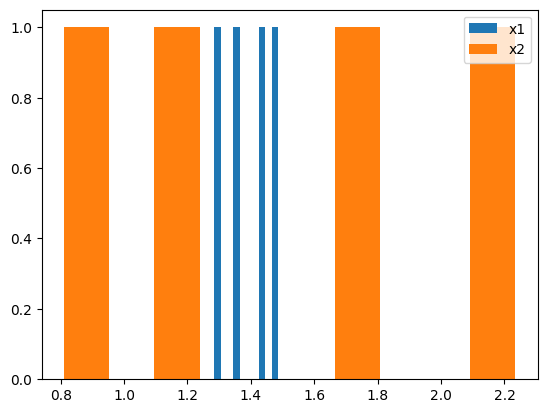

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as stats

mu1 = 1.24 
std1 = 0.11

mu2 = 1.30 
std2 = 0.5


# genreate four points from each gaussian distribution: 
np.random.seed(0)
x1 = np.random.normal(mu1, std1, 4)
x2 = np.random.normal(mu2, std2, 4)

# plot the data
plt.figure()
plt.hist(x1, label='x1')
plt.hist(x2, label='x2')
plt.legend()
plt.show()




## Raster Scan
We will perform a Raster Scan to see which mu and std values are optimal. 

A few notes on Raster Scans: 
- too few points: we skip over the important areas. 
- too many points: the scan takes a long time 
- dimensionality: increases 
- also, certain combinations of parameters can create false minima

In [ ]:
def likelihood(x,mu, std): 
    """Define the probability density function of a normal distribution"""
    likelihood = (1/(std*np.sqrt(2*np.pi)))*np.exp(-0.5*((x-mu)/std)**2)
    return likelihood

def log_likelihood(x,mu, std): 
    return np.log(likelihood(x,mu, std))

In [37]:
n_points = 50 
mu_truth = .2
std_truth = .1
# 0. Generate samples from this distribution: 
def gen_points(mu, std, n_points):
    return np.random.normal(mu, std, n_points)

test_points = gen_points(mu_truth, std_truth, n_points)


# preform the raster scan: 
#1. define the scan region: 
n_mu_scan = 100
min_mu = -1
max_mu = 1

n_std_scan = 100 
min_std = -1.5
max_std = 0

mu_scan = np.linspace(min_mu, max_mu, n_mu_scan)
std_scan = np.logspace(min_std, max_std, n_std_scan)

# 2. Generate the points and calculate the log likelihood:

mus_from_scan = []
stds_from_scan = []
likelihoods_from_scan = []
for i, mu in enumerate(mu_scan):
    for j, std in enumerate(std_scan):
        loglike = 0
        for x in test_points:
            loglike += log_likelihood(x, mu, std)
        mus_from_scan.append(mu)
        stds_from_scan.append(std)
        likelihoods_from_scan.append(loglike)



# find the maximum likelihood:
max_likelihood = np.max(likelihoods_from_scan)
max_likelihood_idx = np.argmax(likelihoods_from_scan)
max_likelihood_mu = mus_from_scan[max_likelihood_idx]
max_likelihood_std = stds_from_scan[max_likelihood_idx]


/var/folders/g7/f9_8q8fx7hd605y1w5g3bljw0000gn/T/ipykernel_84079/910947478.py:6: RuntimeWarning: divide by zero encountered in log
  return np.log(likelihood(x,mu, std))


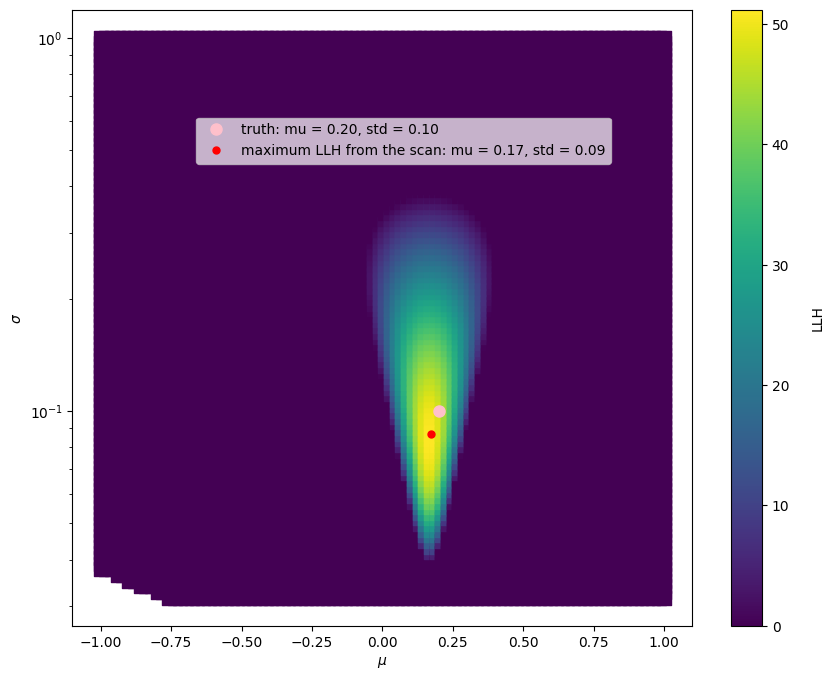

In [39]:


fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)

#raster scan results
sc = ax.scatter(mus_from_scan,stds_from_scan,c=likelihoods_from_scan,
               marker = 's', s = 100, vmin = 0, cmap = 'viridis')

ax.plot(mu_truth, std_truth, marker = 'o', ls='none',
        color = 'pink',markersize = 8, label = f'truth: mu = {mu_truth:.2f}, std = {std_truth:.2f}')
# #the truth
ax.plot(max_likelihood_mu, max_likelihood_std, marker = 'o', ls='none',
        color = 'red',markersize = 5, label = f'maximum LLH from the scan: mu = {max_likelihood_mu:.2f}, std = {max_likelihood_std:.2f}')


# #the maximum of the raster scan LLH
# ax.plot(mus_from_grid[ind_max_llh],sigmas_from_grid[ind_max_llh], marker = 'o', ls='none',
#         color = 'black',markersize = 10, label = 'maximum LLH from the scan')

ax.set_yscale('log')
ax.legend(loc = (0.2,0.75), fontsize = 10,framealpha=0.7,frameon=True)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\sigma$')

cb = fig.colorbar(sc,label='\nLLH')


## Exercise 2: 

Multi-parameter likelihood

Given a theoretical prediction with two independent parameters $\alpha, \beta$

$$
f(x;\alpha, \beta) = 1 + \alpha x + \beta x^2
$$

* the function is not normalized, but the PDF is. 
* generate 2000 monte carlo data points using the above function transformed into a PDF over the range -1<=x<=1

* I normalize the function by analytically solving the integral: 
$$\int_{-1}^1 f(x;\alpha, \beta) = 1 + \alpha x + \beta x^2 dx = \text{Normalizing Factor} = 2 + \frac{2}{3}\beta
$$
* and then I divide the outputs by this.

### MC accept/reject to output samples: 
1. define a uniformed range of x values to investigate 
2. run these values through the function of interest and define bounds for the y axis 
3. generate uniform samples of x and y in this bounded region of x and y. Leave the random y values alone, and send the x values through your function. 
4. Based on the output values of the f(x_rand), reject the (x,y) pairs (that are random and not actually correlated at all), based on wether the f(rand)< > the rand_y
5. Make sure to normalize the likelihood function that you use to generate the f()

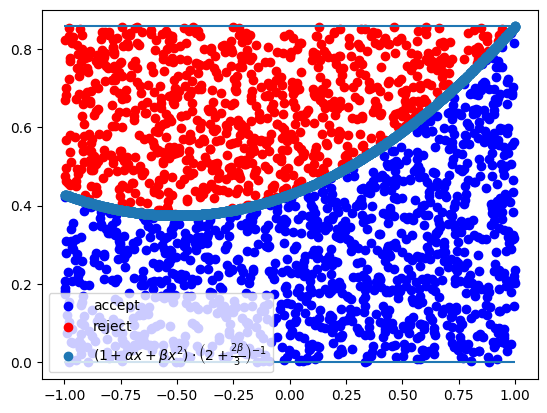

In [84]:
# Define the ground truth parameters: 
alpha_true = .5
beta_true = .5

# Generate the data:
def normalized_likelihood(x, alpha, beta):
    y = 1 + alpha*x + beta*x**2
    norm_factor = 2 + 2/3*beta
    if np.any(y < 0):
        print('y is less than 0')
        return 0
    else: 
        return y/norm_factor

def log_likelihood(x, alpha, beta):
    return np.sum(np.log(normalized_likelihood(x, alpha, beta)))

# TODO: do we need to normalize this data? Yes, using a definite integral.

#
n_samples = 2000
x = np.random.uniform(-1, 1, n_samples)
y = normalized_likelihood(x, alpha_true, beta_true)
y_min = 0#np.min(y)
y_max = np.max(y)

# the proposed x range: 
x_rand = np.random.uniform(-1, 1, n_samples)
# proposed y range:
y_rand = np.random.uniform(y_min, y_max, n_samples)
# generate the accept/reject probability based on the sampled x values: 
evaluated_y = normalized_likelihood(x_rand, alpha_true, beta_true)

# here are the list of True/False values that we can use to grab the future indices. 
accept = y_rand < evaluated_y
reject = y_rand >= evaluated_y

# plot the data:
plt.scatter(x_rand[accept], y_rand[accept], color='blue', label='accept')   
plt.scatter(x_rand[reject], y_rand[reject], color='red', label='reject')



plt.hlines(y_min, -1, 1)
plt.hlines(y_max, -1, 1)

plt.scatter(x, y,label = r'$(1 + \alpha x + \beta x^2)\cdot \left(2 + \frac{2\beta}{3}\right)^{-1}$')
plt.legend()
plt.show()


Text(0, 0.5, '$f(x)$')

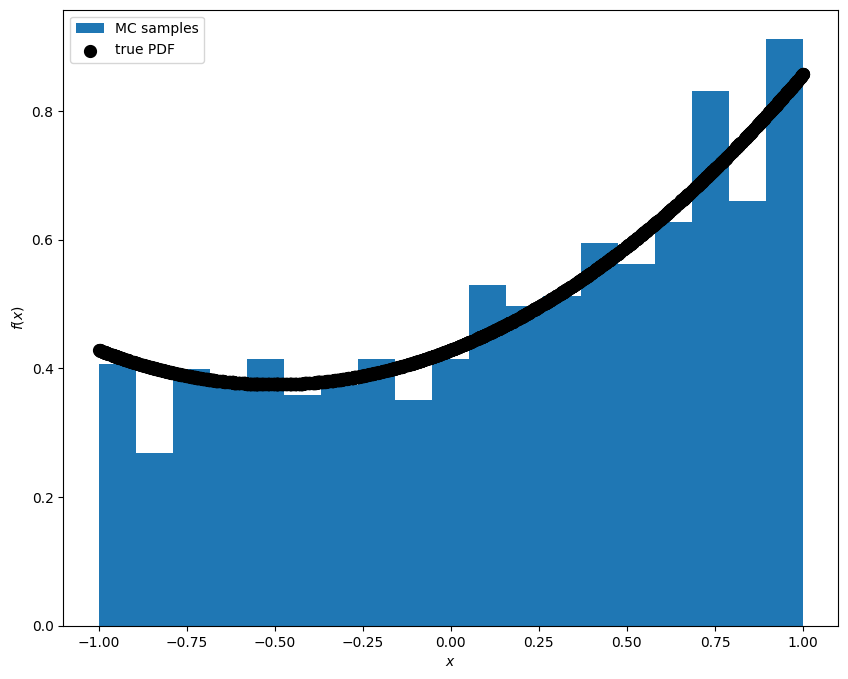

In [85]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)

# #we will be displaying the normalized histogram (density = True)...
ax.hist(x_rand[accept],bins=np.linspace(-1,1,20),density=True,label = 'MC samples')

#...so that we can (again) plot the normalized the PDF on top of it:
ax.scatter(x,y, ls = '-', color = 'black', lw = 3.5, 
        label = r'true PDF')

ax.legend(loc = 'upper left',frameon = True)

ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')

A weird note about this plot is that I had to increase the number of samples below the line. So I extended the y_rand random sample range from the min of the function to 0. I think this makes sense because this is how we have bounded our function for the normalization.

Now, write a numerical optimizer code to fund the best $\alpha$ and $\beta$ values, and optimize for the maximum log likelihood. 

## Numberical Minimization Ends: 
- estimated distance to minima (EDM) it's a criterion for setting up the numerical optimization.

- so I was a bit confused about which data I should input into the minimizer. I think it should be the MC accepted data. **YES, it should be the sampled MC data**

In [91]:
# Generate the data:
def normalized_likelihood_alpha_beta(x, alpha, beta):
    y = 1 + alpha*x + beta*x**2
    norm_factor = 2 + 2/3*beta
    if np.any(y < 0):
        print('y is less than 0')
        return 0    
    else: 
        return y/norm_factor
    
# Define the negative log-likelihood function
def neg_log_likelihood(params, x):
    alpha, beta = params
    return -np.sum(np.log(normalized_likelihood_alpha_beta(x, alpha, beta)))

# Example data (replace with your actual data)
#
n_samples = 2000
x = np.random.uniform(-1, 1, n_samples)
y = normalized_likelihood_alpha_beta(x, alpha_true, beta_true)
# Initial guess for the parameters
initial_guess = [.5, .4]

# res = minimize(neg_log_likelihood,x0=[0.3,0.3],bounds=((-0.2,1),(0,1)),method='L-BFGS-B')


# Minimize the negative log-likelihood
result = minimize(neg_log_likelihood, initial_guess, args=(x_rand[accept]),bounds=((-0.2,1),(0,1)),method='L-BFGS-B')

# Print the optimal solution
print(result.x)  # Optimal solution

[0.55895703 0.45680107]


## Numerical Minimization Notes: 

* be careful with the direction of minimization 
* be careful with dimensionality: 

In [106]:
import numpy as np

def scan_log_likelihood(likelihood_function, test_points, param_ranges, n_scans):
    """
    Perform a raster scan to find the maximum likelihood parameters.

    Parameters:
    - likelihood_function: The likelihood function to be maximized.
    - test_points: The data points to be used in the likelihood calculation.
    - param_ranges: A dictionary with parameter names as keys and tuples of (min, max) as values.
    - n_scans: A dictionary with parameter names as keys and the number of scan points as values.

    Returns:
    - max_likelihood_params: A dictionary with parameter names as keys and the maximum likelihood values as values.
    - max_likelihood: The maximum likelihood value.
    """

    # Generate the scan points for each parameter
    scan_points = {}
    for param, (min_val, max_val) in param_ranges.items():
        if param in n_scans:
            if min_val < 0:
                scan_points[param] = np.logspace(min_val, max_val, n_scans[param])
            else:
                scan_points[param] = np.linspace(min_val, max_val, n_scans[param])

    # Initialize lists to store the results
    param_combinations = []
    loglikelihoods = []

    # Perform the raster scan
    for param_values in np.array(np.meshgrid(*scan_points.values())).T.reshape(-1, len(scan_points)):
        param_dict = dict(zip(scan_points.keys(), param_values))
        loglike = 0
        for x in test_points:
            loglike += likelihood_function(x, **param_dict)
            # save the param key values pairs

        param_combinations.append(param_values)
        loglikelihoods.append(loglike)

    # Find the maximum likelihood
    max_likelihood = np.max(loglikelihoods)
    max_likelihood_idx = np.argmax(loglikelihoods)
    max_likelihood_params = param_combinations[max_likelihood_idx]

    param_combinations = np.array(param_combinations).T
    return max_likelihood_params, max_likelihood, param_combinations, loglikelihoods

# Example usage
def example_likelihood(x, mu, std):
    return -0.5 * ((x - mu) / std)**2 - np.log(std * np.sqrt(2 * np.pi))

n_samples = 2000
x = np.random.uniform(-1, 1, n_samples)

param_ranges = {'alpha': (.3,.7), 'beta': (.3,.7)}
n_scans = {'alpha': 100, 'beta': 100}

max_likelihood_params, max_likelihood, param_combinations, loglikelihoods = scan_log_likelihood(normalized_likelihood_alpha_beta, test_points, param_ranges, n_scans)
print("Max likelihood parameters:", max_likelihood_params)
print("Max likelihood value:", max_likelihood)

Max likelihood parameters: [0.7 0.7]
Max likelihood value: 70.06204648447059


In [105]:
np.array(param_combinations).T.shape

(2, 10000)

In [110]:
max_likelihood_params

array([0.7, 0.7])

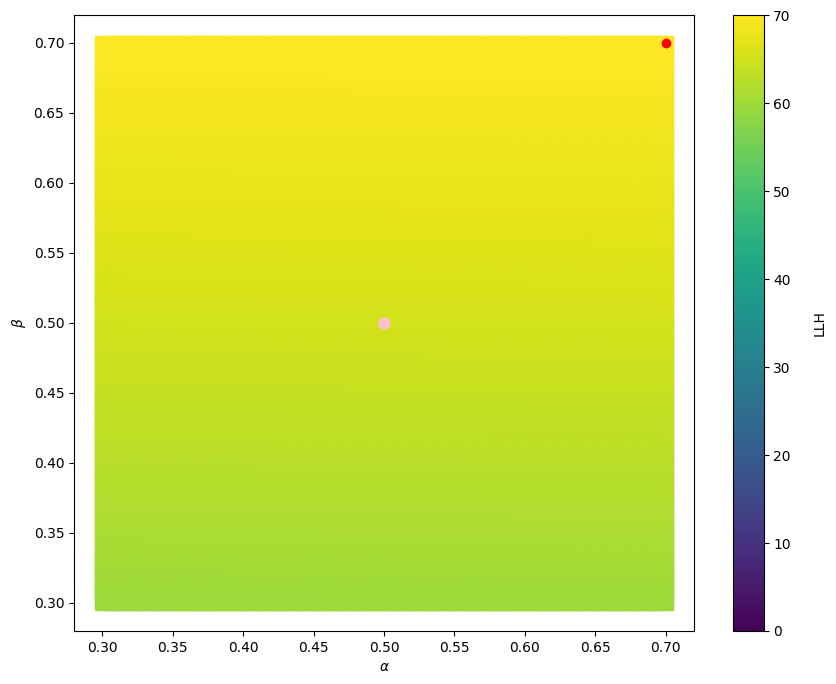

In [ ]:

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)

#raster scan results
sc = ax.scatter(param_combinations[0],param_combinations[1],c=loglikelihoods,
               marker = 's', s = 100, vmin = 0, cmap = 'viridis')

ax.plot(alpha_true, beta_true, marker = 'o', ls='none',
        color = 'pink',markersize = 8, label = f'truth: mu = {mu_truth:.2f}, std = {std_truth:.2f}')
# #the truth
ax.scatter(max_likelihood_params[0], max_likelihood_params[1], color = 'red',label = f'maximum LLH from the gradient descent {np.round(max_likelihood)}')


# #the maximum of the raster scan LLH
# ax.plot(mus_from_grid[ind_max_llh],sigmas_from_grid[ind_max_llh], marker = 'o', ls='none',
#         color = 'black',markersize = 10, label = 'maximum LLH from the scan')



ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.
cb = fig.colorbar(sc,label='\nLLH')